In [13]:
# from google.colab import drive
# drive.mount('/content/gdrive')


In [113]:
import os
import glob
import cv2
from PIL import Image
import tensorflow as tf
from mlxtend.plotting import plot_decision_regions
import warnings
from scipy.stats import uniform, expon, randint

from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from tensorflow.keras.preprocessing.image import img_to_array, load_img

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import load_model, save_model, Model
from keras.layers import Flatten, Dense, Conv2D, Dropout, BatchNormalization, AveragePooling2D, LeakyReLU, GlobalAveragePooling2D, MaxPooling2D, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.efficientnet_v2 import preprocess_input as preprocess_input_efficientnet
from keras.applications import EfficientNetV2L
from keras.applications.mobilenet_v3 import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input as preprocess_input_mobilenet
from keras import regularizers

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *
from utils.functions import *

# import pandas as pd
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
# import joblib


In [135]:
processed_images_path = r'data\processed\images'
df_images_data_original = pd.read_csv(r'data\processed\images_data_processed.csv')

# df_images_data_original = pd.read_csv('/content/gdrive/My Drive/images_data_processed.csv')
# processed_images_path = r'/content/gdrive/My Drive/images'

df_images_data_original.head()


Id    Shape  Weight Clarity Colour Cut Polish Symmetry Fluorescence  \
0  1638147  CUSHION    0.55     SI2      E  EX     EX       VG            N   
1  1630155  CUSHION    0.50    VVS1  FANCY  EX     EX       VG            F   
2  1612606  CUSHION    0.51     VS2      H  EX     EX       VG            N   
3  1638140  CUSHION    0.50     VS2      H  EX     EX       VG            N   
4  1536093  CUSHION    0.53     SI1      D  EX     VG       VG            N   

     Messurements    price  
0  5.05-4.35×2.94  1378.65  
1  4.60-4.31×2.92  1379.74  
2  4.71-4.35×2.94  1380.19  
3  4.91-4.26×2.88  1380.61  
4  4.70-4.46×3.01  1383.13

# Modelo provisional: MobilenetV3Large

- Se prueban muchos modelos (VGG16, Resnet50...) con sus diferentes versiones, pero no se guardan porque el código es largo y complicaría innecesariamente la revisión del "notebook". La arquitectura y el funcionamiento es similar, solo cambia el tamaño del "input"

- Al final, se utiliza un modelo MobileNetV3Large, que es potente, relativamente moderno, de una fuente confiable (Google), y que se ha demostrado eficaz para la detección de imágenes

- Como es muy lento, se pone en marcha en Google Collab y se aprovecha la GPU. Las partes del código solo usadas en Collab se encuentran comentadas

- Como la predicción no es muy buena, se considera provisional. Un segundo modelo usará esa predicción junto con el peso de los diamantes para obtener un precio más ajustado a la realidad

## Ejecución

In [ ]:
# Se adaptan las imágenes al tamaño correcto para el "input"
for image_path in glob.glob(processed_images_path+'/*.jpg'):
    with Image.open(image_path) as image:
        image = image.resize((224, 224))
        image.save(image_path)


In [136]:
# Se lleva a cabo un escalado y modificación de la "Id" para que las imágenes sean reconocibles para el "generator" a partir del "dataframe"
df_images_data = df_images_data_original.copy()

df_images_data['Id'] = df_images_data['Id'].apply(lambda x: x + '.jpg')

scaler = StandardScaler()

df_images_data['price'] = scaler.fit_transform(df_images_data[['price']])

df_images_data = df_images_data[['Id', 'price']]

df_images_data.head()


Id     price
0  1638147.jpg -0.579172
1  1630155.jpg -0.577234
2  1612606.jpg -0.576434
3  1638140.jpg -0.575688
4  1536093.jpg -0.571209

In [117]:
# Se crean dos "dataframes", uno de "train" y uno de "test"
X_train, X_test, y_train, y_test = train_test_split(df_images_data['Id'], df_images_data.drop(columns='Id'), train_size=0.8, random_state=42)

df_train = pd.concat((X_train, y_train), axis=1)
df_test = pd.concat((X_test, y_test), axis=1)

df_train.head()


Id     price
665   1638121.jpg  1.478931
4058  1770787.jpg  0.639604
3929  1784542.jpg  0.611201
910   1771151.jpg -0.672559
1074  1794356.jpg -0.982687

In [7]:
# Se prepara la "augmentation" de las imágenes. Nótese el detalle de que, dado que el diamante es lo único realmente visible y relevante, el fondo desconocido tras las rotaciones se rellena con el color del fondo real
data_augmentation = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        validation_split=0.3,
                                        fill_mode='constant',
                                        cval=(176+177+181) / 3,
                                        preprocessing_function=preprocess_input_mobilenet
                                        )


In [8]:
# Se ponen en marcha los generadores
train_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        subset='training',
                                                        batch_size=256
                                                        )

validation_generator = data_augmentation.flow_from_dataframe(dataframe=df_train,
                                                                directory=processed_images_path,
                                                                target_size=(224, 224),
                                                                class_mode='raw',
                                                                shuffle=False,
                                                                x_col='Id',
                                                                y_col=list(df_images_data.columns[1:]),
                                                                seed=42,
                                                                subset='validation',
                                                                batch_size=256
                                                                )

test_generator = data_augmentation.flow_from_dataframe(dataframe=df_test,
                                                        directory=processed_images_path,
                                                        target_size=(224, 224),
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        x_col='Id',
                                                        y_col=list(df_images_data.columns[1:]),
                                                        seed=42,
                                                        batch_size=256
                                                        )


Found 2399 validated image filenames.
Found 1028 validated image filenames.
Found 857 validated image filenames.


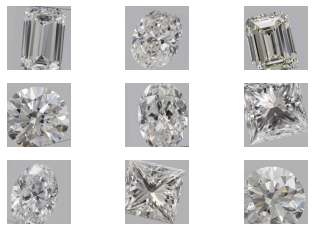

In [ ]:
# Se visualizan algunas de las imágenes creadas
augmented_images, _ = train_generator.next()
augmented_images /= 255

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


In [ ]:
# Se comprueba la GPU
# print(tf.test.gpu_device_name())


/device:GPU:0


In [9]:
# Se prepara la arquitectura y se entrena y modifica la capa superior del modelo
tf.random.set_seed(42)

base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output

top_model = GlobalAveragePooling2D()(top_model)

top_model = Dense(1024, activation='relu')(top_model)

top_model = Dense(512, activation='relu')(top_model)

top_model = Dense(256, activation='relu')(top_model)

top_model = Dense(128, activation='relu')(top_model)

top_model = Dense(64, activation='relu')(top_model)

top_model = Dense(32, activation='relu')(top_model)

top_model = Dense(16, activation='relu')(top_model)

top_model = Dense(8, activation='relu')(top_model)

output_layer = Dense(1, activation='linear')(top_model)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# el "with" es solo para Collab, donde se usa la GPU para almacenar las imágenes
# with tf.device('/device:GPU:0'):
history = model.fit(train_generator,
                    epochs=100,
                    batch_size=128,
                    validation_data=validation_generator,
                    callbacks=[early_stop, reduce_lr]
                    )


12683000/12683000 [==============================] - 2s 0us/step
Epoch 1/100
10/10 [==============================] - 1911s 194s/step - loss: 0.8453 - val_loss: 0.7015 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 38s 4s/step - loss: 0.6462 - val_loss: 0.6092 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 38s 4s/step - loss: 0.5767 - val_loss: 0.6279 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 38s 4s/step - loss: 0.5576 - val_loss: 0.6071 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 38s 4s/step - loss: 0.5504 - val_loss: 0.5959 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 38s 4s/step - loss: 0.5444 - val_loss: 0.5770 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 38s 4s/step - loss: 0.5295 - val_loss: 0.5892 - lr: 0.0010
Epoch 8/100
10/10 [==============================] - 38s 4s/step - loss: 0.5461 - val_loss: 0.5715 - lr: 0.0010
Epoch 9/100
10/10 [================

In [10]:
# Se visualizan las predicciones. Son mejorables
y_pred = model.predict(test_generator)
y_pred = scaler.inverse_transform(y_pred)

metrics_dict = dict()
for index, col in enumerate(df_images_data.columns[1:]):
    rmse = mean_squared_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred], squared=False)
    mse = mean_squared_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    mae = mean_absolute_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    r2 = r2_score([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    mape = mean_absolute_percentage_error([row[index] for row in scaler.inverse_transform(test_generator.labels)], [row[index] for row in y_pred])
    metrics_dict[col] = {'mse': mse,
                            'rmse': rmse,
                            'mae': mae,
                            'r2': r2,
                            'mape': mape
                         }

metrics_dict


4/4 [==============================] - 475s 157s/step


{'price': {'mse': 159148.93149334853,
  'rmse': 398.9347459088372,
  'mae': 289.7887980618026,
  'r2': 0.4880533714163491,
  'mape': 0.19869874196174445}}

In [11]:
df_price = pd.DataFrame(data={'Original': [row[0] for row in scaler.inverse_transform(test_generator.labels)], 'Prediction': [row[0] for row in y_pred]})

df_price


Original   Prediction
0     1788.05  1893.134399
1     1497.46  1966.037964
2     2032.24  1920.503906
3     2039.59  2030.276001
4     1407.85  1301.085815
..        ...          ...
852   2123.92  1984.700195
853   1458.81  1502.853027
854   2448.28  2002.525635
855   2223.08  1792.144287
856   1515.12  1998.935547

[857 rows x 2 columns]

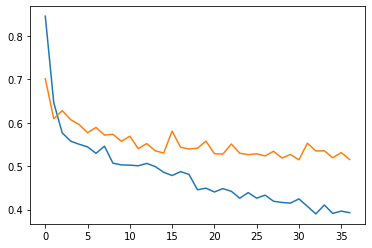

In [12]:
# Se visualiza la gráfica de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.show()


## Guardado del modelo

- Se guarda el modelo para poder trabajarlo en local

In [13]:
# Se guarda el modelo para poder trabajarlo en local
# save_model(model, '/content/gdrive/My Drive/price_prediction_images.h5')


# Modelo definitivo

- Se decide crear un modelo de "machine learning" que trate de mejorar la predicción del precio de los diamantes a partir del peso y de la predicción provisional hecha anteriormente por la red neuronal. Se hace así por ser más transparentes que las redes neuronales, lo que permite elegir uno u otro en función del comportamiento de los datos más fácilmente

- Se hace un "baseline" de modelos supervisados. Se encuentra que SVR es el más adecuado por tener buenas métricas y poca variación, y se optimiza con el "kernel" lineal para aproximar el aumento del precio de los diamantes al subir su peso, así como para tener en cuenta que la predicción final debería crecer a medida que la provisional aumenta

- Si bien el precio de los diamantes en relación a su peso es exponencial, eso solo es determinante cuando el peso de los diamantes es elevado. Para diamantes pequeños, puede considerarse que es casi lineal; de ahí que se seleccione SVR con ese "kernel" (los diamantes de los que se dispone no son muy grandes en su mayoría)

## Carga de resultados provisionales

- Lo primero es obtener un precio provisional de los diamantes de los que se dispone aplicándoles el otro modelo

In [4]:
model_nn = load_model(r'models\predict_from_images\price_prediction_images.h5')

model_nn


In [137]:
df_images_final = df_images_data_original.copy()

df_images_final = df_images_final[['Id', 'Weight', 'price']]

df_images_final['Id'] = df_images_final['Id'].apply(lambda x: x + '.jpg')

df_images_final['price'] = scaler.transform(df_images_final[['price']])

scaler_weight = StandardScaler()

df_images_final['Weight'] = scaler_weight.fit_transform(df_images_final[['Weight']])

df_images_final.head()


Id    Weight     price
0  1638147.jpg  0.068554 -0.579172
1  1630155.jpg -0.181520 -0.577234
2  1612606.jpg -0.131505 -0.576434
3  1638140.jpg -0.181520 -0.575688
4  1536093.jpg -0.031475 -0.571209

In [138]:
df_images_final['predicted_price'] = 0

for image_path in glob.glob(processed_images_path+'/*.jpg'):
    with Image.open(image_path) as img:
        image_name = image_path.split('\\')[-1]
        img = img.resize((224, 224))
        img = preprocess_input_mobilenet(img)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model_nn.predict(img_array)
        df_images_final.loc[df_images_final['Id'] == image_name, 'predicted_price'] = prediction


1/1 [==============================] - 1s 786ms/step


In [142]:
df_images_final = df_images_final.drop(columns='Id')

df_images_final.head()


Weight     price  predicted_price
0  0.068554 -0.579172         0.240250
1 -0.181520 -0.577234        -0.082174
2 -0.131505 -0.576434        -0.128051
3 -0.181520 -0.575688         0.349721
4 -0.031475 -0.571209         0.819886

## Baseline de "machine learning"


In [11]:
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'SVR',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'SVR': '',
 'XGBRegressor': ''}

In [143]:
baseline = Regression(df_images_final, 'price')
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ])
baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.15 sec(s). Total time: 0.15
Starting Ridge:
- Ridge done in 0.1 sec(s). Total time: 0.26
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.18 sec(s). Total time: 0.44
Starting SVR:
- SVR done in 3.27 sec(s). Total time: 3.7
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.18 sec(s). Total time: 3.89
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 10.37 sec(s). Total time: 14.26
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 2.36 sec(s). Total time: 16.61


LinearRegression     Ridge  KNeighborsRegressor       SVR  \
rmse              0.586366  0.586366             0.581191  0.545719   
mse               0.343994  0.343993             0.338383  0.298323   
mae               0.449533  0.449578             0.413259  0.378568   
r2_score          0.654683  0.654686             0.660181  0.699933   
mape              1.972141  1.971235             1.701922  1.551019   

          DecisionTreeRegressor: random_state=43  \
rmse                                    0.763953   
mse                                     0.584450   
mae                                     0.534801   
r2_score                                0.414259   
mape                                    2.633210   

          RandomForestRegressor: random_state=43  \
rmse                                    0.614327   
mse                                     0.378077   
mae                                     0.439956   
r2_score                                0.620055   
mape                                    1.932162   

          XGBRegressor: random_state=43 BEST  \
rmse                           0.590749  SVR   
mse                            0.349466  SVR   
mae                            0.418337  SVR   
r2_score                       0.649625  SVR   
mape                           1.725239  SVR   

                                           WORST  
rmse      DecisionTreeRegressor: random_state=43  
mse       DecisionTreeRegressor: random_state=43  
mae       DecisionTreeRegressor: random_state=43  
r2_score           XGBRegressor: random_state=43  
mape      DecisionTreeRegressor: random_state=43

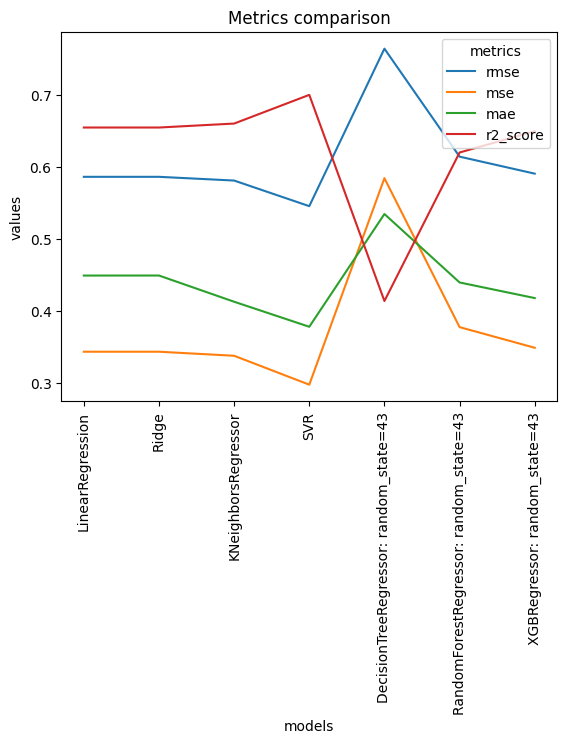

In [144]:
baseline.visualize('rmse', 'mse', 'r2_score', 'mae')


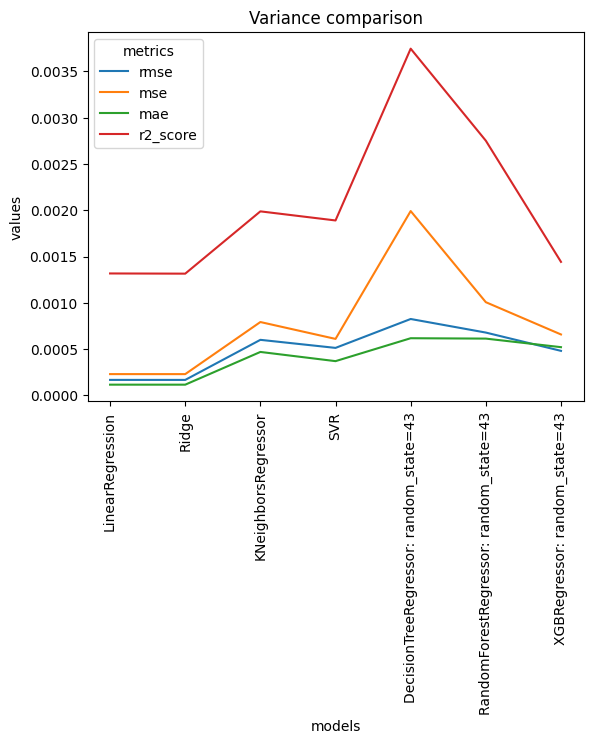

In [145]:
baseline.create_dataframe(chosen_format='variance')
baseline.visualize('rmse', 'mse', 'r2_score', 'mae')


## Optimización SVR "linear"

- Se buscan los mejores parámetros para la predicción

- El modelo resultante predice mejor que la red neuronal sola

### Limpieza

- Se eliminan los diamantes con peso "outlier"

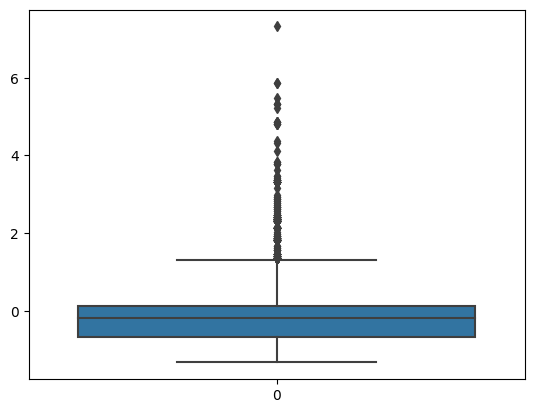

In [146]:
ax = sns.boxplot(df_images_final['Weight'])
plt.show()


In [147]:
q3, q1 = np.percentile(df_images_final['Weight'], [75, 25])
iqr = q3 - q1

df_images_final = df_images_final.drop(df_images_final[df_images_final['Weight'] > q3 + 1.5*iqr].index)


In [172]:
baseline = Regression(df_images_final, 'price')
X_train, X_test, y_train, y_test = baseline.split_dataframe()


In [149]:
for kernel in ['poly', 'rbf', 'sigmoid','linear']:
    svr = SVR(kernel=kernel) 
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    print('\n')
    print(kernel)
    print(f'rmse: {mean_squared_error(y_test, y_pred, squared=False)}')
    print(f'mse: {mean_squared_error(y_test, y_pred)}')
    print(f'mae: {mean_absolute_error(y_test,y_pred)}')
    print(f'r2: {r2_score(y_test, y_pred)}')
    print(f'mape: {mean_absolute_percentage_error(y_test, y_pred)}')




poly
rmse: 0.5846023174558131
mse: 0.3417598695747074
mae: 0.4467546728866787
r2: 0.5530757857159
mape: 1.2821930080432762


rbf
rmse: 0.46038779067317914
mse: 0.211956917800931
mae: 0.31883291800193986
r2: 0.7228209412996826
mape: 1.5214003015635145


sigmoid
rmse: 129.50942820611752
mse: 16772.69199427551
mae: 94.71565563788945
r2: -21932.886504284765
mape: 450.9173844493452


linear
rmse: 0.5200046292270375
mse: 0.27040481441754877
mae: 0.39140540594686163
r2: 0.6463878003798704
mape: 1.6825776079066526


### "RandomizedSearch"

- Se empieza con una prueba aleatoria para aproximar los mejores hiperparámetros. A pesar de sus limitaciones, se elige el "kernel" de tipo "linear" ya que, si bien el precio de los diamantes sube de forma exponencial en relación a su peso, en pequeño tamaño esa relación se puede aproximar a una lineal. Además, a mayor predicción previa por parte de la red neuronal, mayor debería ser el precio final

In [150]:
rmse = make_scorer(calculate_rmse, greater_is_better=False)
kfolds = KFold(n_splits=5, shuffle=True, random_state=43)


In [104]:
model = SVR()

params= {'C': uniform(loc=0, scale=10),
            'epsilon': uniform(loc=0, scale=1),
            'shrinking': [True, False],
            'tol': uniform(loc=0, scale=0.1),
            'kernel': ['linear']
            }

grid = RandomizedSearchCV(estimator=model,
                            param_distributions=params,
                            scoring=rmse,
                            verbose=4,
                            cv=kfolds,
                            n_iter=5000,
                            random_state=42
                            )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
[CV 1/5] END C=3.745401188473625, epsilon=0.9507143064099162, kernel=linear, shrinking=True, tol=0.07796910002727693;, score=-0.555 total time=   0.0s
[CV 2/5] END C=3.745401188473625, epsilon=0.9507143064099162, kernel=linear, shrinking=True, tol=0.07796910002727693;, score=-0.541 total time=   0.0s
[CV 3/5] END C=3.745401188473625, epsilon=0.9507143064099162, kernel=linear, shrinking=True, tol=0.07796910002727693;, score=-0.550 total time=   0.0s
[CV 4/5] END C=3.745401188473625, epsilon=0.9507143064099162, kernel=linear, shrinking=True, tol=0.07796910002727693;, score=-0.547 total time=   0.0s
[CV 5/5] END C=3.745401188473625, epsilon=0.9507143064099162, kernel=linear, shrinking=True, tol=0.07796910002727693;, score=-0.517 total time=   0.0s
[CV 1/5] END C=5.96850157946487, epsilon=0.44583275285359114, kernel=linear, shrinking=True, tol=0.005808361216819946;, score=-0.554 total time=   0.2s
[CV 2/5] END C=5.9685015794

### "GridSearch"

- Se itentan acotar los parámetros ganadores del "RandomSearch" con algunos "GridSearch"

In [105]:
model = SVR()

params= {'C': [1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58],
            'epsilon': [0.265, 0.266, 0.267, 0.268, 0.269, 0.27],
            'kernel': ['linear'],
            'shrinking': [False],
            'tol': [0.085, 0.086, 0.087, 0.088, 0.089, 0.09],
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    verbose=4,
                    cv=kfolds
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV 1/5] END C=1.52, epsilon=0.265, kernel=linear, shrinking=False, tol=0.085;, score=-0.556 total time=   0.3s
[CV 2/5] END C=1.52, epsilon=0.265, kernel=linear, shrinking=False, tol=0.085;, score=-0.534 total time=   0.3s
[CV 3/5] END C=1.52, epsilon=0.265, kernel=linear, shrinking=False, tol=0.085;, score=-0.537 total time=   0.3s
[CV 4/5] END C=1.52, epsilon=0.265, kernel=linear, shrinking=False, tol=0.085;, score=-0.536 total time=   0.2s
[CV 5/5] END C=1.52, epsilon=0.265, kernel=linear, shrinking=False, tol=0.085;, score=-0.497 total time=   0.2s
[CV 1/5] END C=1.52, epsilon=0.265, kernel=linear, shrinking=False, tol=0.086;, score=-0.556 total time=   0.3s
[CV 2/5] END C=1.52, epsilon=0.265, kernel=linear, shrinking=False, tol=0.086;, score=-0.534 total time=   0.2s
[CV 3/5] END C=1.52, epsilon=0.265, kernel=linear, shrinking=False, tol=0.086;, score=-0.537 total time=   0.2s
[CV 4/5] END C=1.52, epsilon=0.265, kern

### Resolución

- Se obtienen los mejores hiperparámetros y se evalúa el resultado

In [163]:
# Estos son los mejores hiperparámetros
final_model = SVR(C=1.53,
                  epsilon=0.266,
                  kernel='linear',
                  shrinking=True,
                  tol=0.087
                    )

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)


In [164]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1))
previous_price = scaler.inverse_transform(X_test[['predicted_price']])


In [169]:
df_price = pd.DataFrame(data={'Original': [row[0] for row in y_test], 'Prediction': [row[0] for row in y_pred]})

df_price


Original   Prediction
0      2304.43  1843.714364
1      1384.24  1635.531332
2      1532.05  1945.479100
3      1972.16  1928.955076
4       994.18  1634.809448
...        ...          ...
1152   2061.11  1627.274839
1153   2068.73  1899.054575
1154   1002.83   915.718512
1155   1534.52  1937.582142
1156   1099.75   938.506597

[1157 rows x 2 columns]

In [170]:
# Estas son las mejores métricas posibles
print(f'rmse: {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')
print(f'mae: {mean_absolute_error(y_test,y_pred)}')
print(f'r2: {r2_score(y_test, y_pred)}')
print(f'mape: {mean_absolute_percentage_error(y_test, y_pred)}')


rmse: 286.7288476373926
mse: 82213.4320674671
mae: 225.90079901088814
r2: 0.6603374878468087
mape: 0.15440031221100625


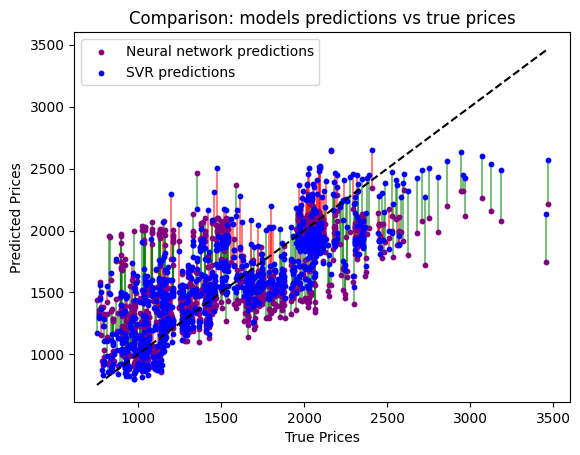

In [171]:
# Aquí puede verse cómo el SVR modifica las predicciones previas de la red neuronal. Las línes verdes indican una mejora
fig, ax = plt.subplots()
ax.scatter(y_test, previous_price, s=10, c='purple', label='Neural network predictions')
ax.scatter(y_test, y_pred, s=10, c='blue', label='SVR predictions')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
ax.set_xlabel('True Prices')
ax.set_ylabel('Predicted Prices')
ax.legend()
ax.set_title('Comparison: models predictions vs true prices')

for i in range(len(y_test)):
    if previous_price[i] != y_pred[i]:
        if abs(previous_price[i] - y_test[i]) < abs(y_pred[i] - y_test[i]):
            ax.plot([y_test[i], y_test[i]], [previous_price[i], y_pred[i]], color='red', alpha=0.5, zorder=0)
        else:
            ax.plot([y_test[i], y_test[i]], [previous_price[i], y_pred[i]], color='green', alpha=0.5, zorder=0)

plt.show()


## Optimización SVR "rbf"


### Limpieza

- Se eliminan los diamantes con peso "outlier"

In [ ]:
ax = sns.boxplot(df_images_final['Weight'])
plt.show()


In [ ]:
q3, q1 = np.percentile(df_images_final['Weight'], [75, 25])
iqr = q3 - q1

df_images_final = df_images_final.drop(df_images_final[df_images_final['Weight'] > q3 + 1.5*iqr].index)


In [ ]:
baseline = Regression(df_images_final, 'price')
X_train, X_test, y_train, y_test = baseline.split_dataframe()


In [ ]:
for kernel in ['poly', 'rbf', 'sigmoid','linear']:
    svr = SVR(kernel=kernel) 
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    print('\n')
    print(kernel)
    print(f'rmse: {mean_squared_error(y_test, y_pred, squared=False)}')
    print(f'mse: {mean_squared_error(y_test, y_pred)}')
    print(f'mae: {mean_absolute_error(y_test,y_pred)}')
    print(f'r2: {r2_score(y_test, y_pred)}')
    print(f'mape: {mean_absolute_percentage_error(y_test, y_pred)}')


### "RandomizedSearch"

In [ ]:
model = SVR()

params= {'C': uniform(loc=0, scale=10),
            'epsilon': uniform(loc=0, scale=1),
            'shrinking': [True, False],
            'tol': uniform(loc=0, scale=0.1),
            'kernel': ['rbf']
            }

grid = RandomizedSearchCV(estimator=model,
                            param_distributions=params,
                            scoring=rmse,
                            verbose=4,
                            cv=kfolds,
                            n_iter=5000,
                            random_state=42
                            )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')
